In [27]:
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam

In [2]:
def load_mnist_dataset(dataset_path):
    def load_mnist_imgs(imgs_file_name):
        imgs_file_path = os.path.join(dataset_path, imgs_file_name)
        with open(imgs_file_path, "rb") as fd:
            magic = int.from_bytes(fd.read(4), "big")
            size = int.from_bytes(fd.read(4), "big")
            nrows = int.from_bytes(fd.read(4), "big")
            ncols = int.from_bytes(fd.read(4), "big")
            imgs = np.frombuffer(fd.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))
            imgs = imgs.reshape((size, nrows, ncols))
        return imgs
    def load_mnist_labels(labels_file_name):
        labels_file_path = os.path.join(dataset_path, labels_file_name)
        with open(labels_file_path, "rb") as fd:
            magic = int.from_bytes(fd.read(4), "big")
            size = int.from_bytes(fd.read(4), "big")
            labels = np.frombuffer(fd.read(), dtype=np.dtype(np.uint8).newbyteorder('>'))
        return labels
    
    train_imgs = load_mnist_imgs("train-images-idx3-ubyte")
    train_labels = load_mnist_labels("train-labels-idx1-ubyte")
    
    test_imgs = load_mnist_imgs("t10k-images-idx3-ubyte")
    test_labels = load_mnist_labels("t10k-labels-idx1-ubyte")
    
    return train_imgs, train_labels, test_imgs, test_labels

In [3]:
train_imgs, train_labels, test_imgs, test_labels = load_mnist_dataset("./data/datasets/MNIST")

In [50]:
class CrappyNet(nn.Module):
    def __init__(self, img_size):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 5, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(5, 10, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 5, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(5, 5, 3, padding=1),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(5 * img_size[0] * img_size[1], 10)
        )
        
    def forward(self, imgs):
        N,C,H,W = imgs.shape
        features = self.conv(imgs)
        logits = self.fc(features.view(N, -1))
        return logits
    
    def nll(self, imgs, labels):
        imgs = torch.tensor(imgs, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        labels = torch.unsqueeze(labels, 1)
        logits = self(imgs)
        probs = F.softmax(logits, dim=1)
        nlog_probs = -torch.log(probs.gather(1, labels))
        return nlog_probs.sum()
    
    def predict_labels(self, imgs):
        imgs = torch.tensor(imgs, dtype=torch.float32)
        with torch.no_grad():
            logits = self(imgs)
            _, labels = logits.max(1)
        return labels
        

In [51]:
def train(model, train_loader, optimizer):
    model.train()
    train_losses = []
    for imgs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        loss = model.nll(imgs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return train_losses
        
def test(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            loss = model.nll(imgs, labels)
            test_loss += loss.item() * len(labels)
    return test_loss / len(test_loader.dataset)

def percentace_correct(model, test_loader):
    model.eval()
    num_correct = 0
    for imgs, labels in test_loader:
        predicted_labels = model.predict_labels(imgs)
        num_correct += (labels == predicted_labels).sum()
    return num_correct / len(test_loader.dataset)
        
def train_epochs(model, train_loader, test_loader, train_args):
    lr = train_args["lr"]
    epochs = train_args["epochs"]
    optimizer = Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = [test(model, test_loader)]
    for epoch in range(epochs):
        print(f"epoch: {epoch+1}")
        train_losses.extend(train(model, train_loader, optimizer))
        test_losses.append(test(model, test_loader))
    return train_losses, test_losses 

In [52]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, imgs, labels):
        N, H, W = imgs.shape
        self.imgs = imgs.reshape(N,1,H,W)
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        return self.imgs[index], self.labels[index]
    
train_dataset = Dataset(train_imgs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = Dataset(test_imgs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

N, H, W = train_imgs.shape
model = CrappyNet((H, W))

train_args = {'lr': 1e-3, 'epochs': 10}
train_losses, test_losses = train_epochs(model, train_loader, test_loader, train_args)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 1


100%|██████████| 938/938 [00:53<00:00, 17.62it/s]


epoch: 2


100%|██████████| 938/938 [01:00<00:00, 15.58it/s]


epoch: 3


100%|██████████| 938/938 [01:03<00:00, 14.81it/s]


epoch: 4


100%|██████████| 938/938 [01:05<00:00, 14.30it/s]


epoch: 5


100%|██████████| 938/938 [01:07<00:00, 13.94it/s]


epoch: 6


100%|██████████| 938/938 [01:06<00:00, 14.00it/s]


epoch: 7


100%|██████████| 938/938 [01:09<00:00, 13.42it/s]


epoch: 8


100%|██████████| 938/938 [01:08<00:00, 13.72it/s]


epoch: 9


100%|██████████| 938/938 [01:10<00:00, 13.27it/s]


epoch: 10


100%|██████████| 938/938 [01:14<00:00, 12.58it/s]


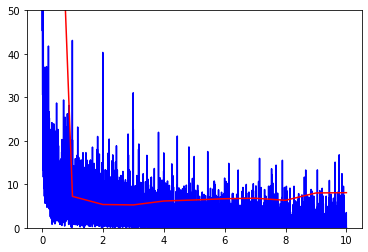

Final Train Loss: 8.583087947044987e-06
Final Test Loss: 8.076665795972477


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Percentage Correct: 0.9772999882698059


In [53]:
# len(train_losses) = number of training iteration
#                   = number of epochs * number of training steps per epoch
# len(test_losses) = number of epochs + 1
def plot_losses(train_losses, test_losses):
    epochs = len(test_losses) - 1
    steps_per_epoch = len(train_losses) / epochs
    train_losses_epochs = [((i+1)/steps_per_epoch) for i in range(len(train_losses))]
    test_losses_epochs = [i for i in range(len(test_losses))]
    plt.plot(train_losses_epochs, train_losses, color="blue")
    plt.plot(test_losses_epochs, test_losses, color="red")
    plt.ylim([0, 50])
    plt.show()
    
plot_losses(train_losses, test_losses)
print(f"Final Train Loss: {train_losses[-1]}")
print(f"Final Test Loss: {test_losses[-1]}")
print(f"Percentage Correct: {percentace_correct(model, test_loader)}")